In [ ]:
!pip install statsmodels
!pip install lets-plot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.4 MB/s eta 0:00:00


In [1]:
import statsmodels.api as sm
from sklearn.linear_model import Ridge

from statsmodels.tsa.stattools import adfuller, kpss, acf as sm_acf, pacf as sm_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.arima.model import ARIMA

from scipy.stats import norm


c:\Users\lawor\anaconda3v0\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

#from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import seaborn as sns

import datetime as dt
import time
import re

from lets_plot import *
LetsPlot.setup_html()

In [ ]:
# from google.colab import files
# import pandas as pd

# # Upload file from local computer
# uploaded = files.upload()

# # Read into DataFrame
# IV_y_values = pd.read_csv('MOVE_index.csv')

## RV FORECASTING CODE STRUCTURE

- Outer Loop: Rolling Window Sizes: Iterate over different rolling window sizes to test how each window size affects model performance.

- Second Loop: Feature Construction for All Estimators. For each window size, compute features using your HAR_Model.features() method. Each estimator (e.g., RV, BV, MedRV, RR) will have its own feature set derived from its volatility series.

- Third Loop: Fit & Predict for Each Estimator. For each estimator: Run fit_predict() using the features and target series. Collect yhat (forecasted volatility) and residuals. Store predictions and residuals for metric evaluation.

- End of Loop.

Metric Computation. For each estimator: Compute QLIKE, MPSE, and optionally other metrics. Plot: QLIKE and MPSE over time. QLIKE mean and variance over time (to assess stability). These plots help visualize performance across time and windows. Residual to be evaluted. Do the same for the ensemble model with weightage to be computed based on metric performance.

In [3]:
class volatility_estimator:
    def __init__(self, add_log):
        self.add_log = add_log

    def _check(self, df):
        required = ['High', 'Low', 'Open', 'Close']
        if not set(required).issubset (df.columns):
            raise ValueError(f"Dataframe needs columns {required}.")
        if (df[required]<=0).any().any():
            raise ValueError(f"Dataframe contains nonpositive values")
        return df

    def compute_square_return(self,df):
        df = self._check(df)
        log_return =  np.log(df['Close'] / df['Close'].shift(1))
        return 252*(log_return ** 2)

    def compute_parkinson_estimator(self,df):
        df = self._check(df)
        log_par_var = (np.log(df['High'] / df['Low']))**2
        return 252*((1/(4*np.log(2))) * log_par_var)

    def compute_gk_estimator(self,df):
        df = self._check(df)
        gk_var_1 = (1/2)*(np.log(df['High']/df['Low']))**2
        gk_var_2 = (2*np.log(2)-1)*(np.log(df['Close']/df['Open']))**2
        return 252*(gk_var_1 - gk_var_2)

    def compute_rs_estimator(self, df):
        df = self._check(df)
        rs_var_1 = (np.log(df['High']/df['Open']))*(np.log(df['High']/df['Close']))
        rs_var_2 = (np.log(df['Low']/df['Open']))*(np.log(df['Low']/df['Close']))
        return 252*(rs_var_1 + rs_var_2)

    def compute_all(self,df):
          df = self._check(df).copy()
          eps = 1e-12

          out = pd.DataFrame(index = df.index)
          out['square_est'] = self.compute_square_return(df)
          out['parkinson_est']=self.compute_parkinson_estimator(df)
          out['gk_est'] = self.compute_gk_estimator(df)
          out['rs_est'] = self.compute_rs_estimator(df)

          if self.add_log:
              for col in ['square_est', 'parkinson_est', 'gk_est', 'rs_est']:
                  x = out[col].astype(float).replace([np.inf, -np.inf], np.nan)
                  out[col + '_log'] = np.log(x.clip(lower=eps))

          return out

In [4]:
# premodel diagnotics on the data assumptions.
import warnings

class Vol_Est_Check:

    def __init__(self,
                 alpha,
                 lb_lags,
                 kpss_reg,
                 kpss_nlags,
                 acf_pacf_nlags):
        # alpha: significant level
        # lb_lags: lags to report to Ljung box
        # kpss: reg[c - level, ct - trend], nlags: auto or int
        #ADF passed stationary when p<0.05 (reject H_0 of unit root)
        self.alpha = alpha
        self.lb_lags = tuple(lb_lags)
        self.kpss_reg = kpss_reg
        self.kpss_nlags = kpss_nlags
        self.acf_pacf_nlags = acf_pacf_nlags

    def ADF(self, df, name):
        df = df.dropna()
        series_name = name or getattr (df, 'name', 'series')

        stat, p, lags, nobs, crit, icbest = adfuller(df, autolag = 'AIC')
        stationary_flag = p <= self.alpha
        return {"adf_stat": stat,
                "adf_p": p,
                "adf_lags": lags,
                "adf_nobs": nobs,
                "adf_crit": crit,
                'adf_icbest': icbest,
                'adf_stationary_flag': stationary_flag,
                'adf_decision': (f'{series_name}: Reject H0 -> stationary'
                    if stationary_flag
                    else 'Fail to reject H0 -> non-stationary'
                )}


    def KPSS(self,df, name, nlags):
        df = df.dropna()
        series_name = name or getattr (df, 'name', 'series')

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            stat, p, lags, crit = kpss(df,
                                       regression=self.kpss_reg,
                                       nlags=nlags)

        stationary_flag = (p > self.alpha)
        return {
            "kpss_stat": stat, # stat < crit -> series is stationary
            "kpss_p": p, # p >0.05  -> series is stationary
            "kpss_lags": lags,
            "kpss_crit": crit,
            'kpss_reg': self.kpss_reg,
            'kpss_stationary_flag': stationary_flag,
            'kpss_decision': (f'{series_name}: Fail to reject H0 ->stationary'
            if stationary_flag
            else f"{series_name}: Reject H0 -> Non-stationary")
            }


    def ljung_box(self, df): # reject H0 -> serial correlation
        df = df.dropna()
        lb = acorr_ljungbox(df, lags=list(self.lb_lags), return_df=True)
        out={}
        for L in self.lb_lags:
            out[f'lb_stat_{L}'] = float(lb.loc[L, "lb_stat"]) # stat for each lag h
            out[f"lb_p_{L}"]   = float(lb.loc[L, "lb_pvalue"])  # p-value

        out['white_noise_flag'] = all(out[f'lb_p_{L}'] > self.alpha for L in self.lb_lags)
        out["lb_lags_used"] = self.lb_lags
        out['n_obs'] = len(df)
        out['name'] = getattr(df, 'name', 'series')
        return out

    def compute_acf(self, df, nlags, alpha):
        df=df.dropna()
        nlags = nlags or self.acf_pacf_nlags
        vals, conf = sm_acf(df,
                            nlags = nlags,
                            alpha = alpha,
                            fft = True,
                            adjusted = False)
        return {'acf_vals': vals,
                'acf_confint': conf} #shape(nlags+1,2)


    def compute_pacf(self, df, nlags, alpha, method: str = 'ywmle'):
        df=df.dropna()
        nlags = nlags or self.acf_pacf_nlags
        vals, conf = sm_pacf(df,
                             nlags=nlags,
                             alpha=alpha,
                             method=method)
        return {
            'pacf_vals': vals,
            'pacf_confint': conf,
            'pacf_method': method
            }

    def plot_acf(self, df, nlags, title:str = None):
        df = df.dropna()
        nlags = nlags or self.acf_pacf_nlags
        plot_acf(df, lags=nlags)
        plt.title(title or f"ACF ({getattr(df,'name','series')})")
        plt.show()

    def plot_pacf(self, df, nlags, title: str = None, method: str = 'ywmle'):
        df = df.dropna()
        nlags = nlags or self.acf_pacf_nlags
        plot_pacf(df, lags=nlags)
        plt.title(title or f"PACF ({getattr(df,'name','series')})")
        plt.show()

    def summarize_series(self, df, name = None): #for 1 estimator
        series_name = name or getattr (df, 'name', 'series')
        results = {}
        results.update(self.ADF(df, name = name))
        results.update(self.KPSS(df, name = name, nlags=self.kpss_nlags))

        lb = self.ljung_box(df)
        results.update({f"lb_{k}": v for k, v in lb.items()})

        return results


In [5]:
#HAR model function
from typing import Iterable, Optional, Dict, Tuple

class HAR_Model:
  def __init__(self, y_log_col, exo_col, lags =[1,5,22]):
    self.y_log_col = y_log_col
    self.exo_col = exo_col
    self.lags = lags #daily, weekly, monthly

  def features(self, df):
    y_pred = df[self.y_log_col]
    out = pd.DataFrame(index=df.index)
    out['rv_d'] = y_pred
    out['rv_w'] = y_pred.rolling(self.lags[1], min_periods = self.lags[1]).mean()
    out['rv_m'] = y_pred.rolling(self.lags[2], min_periods = self.lags[2]).mean()

    if self.exo_col:
      for col in self.exo_col:
        out[f'x_{col}'] =df[col].shift(1)

    return out.dropna()

  def fit_predict(self,
                  x_train,
                  y_train,
                  window):

    resid_full = pd.Series(index=y_train.index, data=np.nan)
    yhat_full = pd.Series(index=y_train.index, data=np.nan)
    residual_raw = pd.Series(index=y_train.index, data=np.nan)
    for t in range(window, len(y_train)):
      y_slice = y_train.iloc[t-window:t]
      x_slice = x_train.iloc[t-window:t]

      common_idx = x_slice.index.intersection(y_slice.index)
      y_slice = y_train.loc[common_idx]
      x_slice = x_train.loc[common_idx]

      model = sm.OLS(y_slice, sm.add_constant(x_slice)).fit()

      x_next = pd.DataFrame([x_train.iloc[t]])
      x_next = sm.add_constant(x_next, has_constant='add')

      yhat_full.iloc[t] = model.predict(x_next).iloc[0]
      resid_full.iloc[t] = model.resid.var(ddof=x_slice.shape[1]) #ddof degree of freedom correction for unbiased variance
      residual_raw.iloc[t] = yhat_full.iloc[t] - y_train.iloc[t]

    return yhat_full, resid_full, residual_raw



In [6]:
# to compute for the ensemble model

class EnsembleModel:
  def __init__(self, estimators):
    self.estimators = estimators

  def compute_weightage(self, qlike, eps=1e-12): # weightage computed by using inverse qlike
    inverse = {k: 1.0/max(v,eps) for k,v in qlike.items()}
    total = sum(inverse.values()) if inverse else 0.0
    weight = {k: v/total for k,v in inverse.items()}
    return weight


In [73]:
# metric computation function

class Metric_Evaluation:
  def __init__(self, ytrue, y_pred, alpha):
    self.y_pred = y_pred
    self.ytrue = ytrue
    self.alpha = alpha

  def mspe(ytrue, ypred):
    return ((ytrue - ypred) / ytrue) ** 2

  def qlike(ytrue, ypred):
    return np.log(ypred) + ytrue / ypred

  def diebold_mariano_test(y_true, pred1, pred2, h=1, loss_type='MSE'):
    # """
    # Diebold-Mariano test for equal predictive accuracY
    # Parameters:
    # y_true: actual values
    # pred1: predictions from model 1
    # pred2: predictions from model 2
    # h: forecast horizon
    # loss_type: 'MSE' or 'QLIKE'
    # """
    if loss_type == 'MSE':
        loss1 = (y_true - pred1) ** 2
        loss2 = (y_true - pred2) ** 2
    elif loss_type == 'QLIKE':
        loss1 = np.log(pred1) + y_true / pred1
        loss2 = np.log(pred2) + y_true / pred2
    else:
        raise ValueError("loss_type must be 'MSE' or 'QLIKE'")

    d = loss1 - loss2
    d = np.asarray(d).flatten()
    d_mean = np.mean(d)
    n = len(d)
    d_centered = d - d_mean

    # HAC variance estimator
    L = np.floor(1.5*n**(1/3))
    gamma_0 = np.mean(d_centered**2)
    for lag in range(1, L+1):
      gamma_lag = np.mean(d_centered[:-lag] * d_centered[lag:])
      w = 1 - lag / (L + 1)
      gamma_0 += 2 * w * gamma_lag

    dm_stat = d_mean / np.sqrt(gamma_0 / n)
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))

    return dm_stat, p_value
  
  
  def DM_test(loss1, loss2, alpha = 0.05, model1_name = 'Model 1', model2_name = 'Model_2'): #confirm using qlike
    d = loss1 - loss2
    d = np.asarray(d).flatten()
    d_mean = np.mean(d)
    n = len(d)
    d_centered = d - d_mean

    # HAC variance estimator
    L = int(np.floor(1.5*n**(1/3)))
    gamma_0 = np.mean(d_centered**2)
    for lag in range(1, L+1):
      gamma_lag = np.mean(d_centered[:-lag] * d_centered[lag:])
      w = 1 - lag / (L + 1)
      gamma_0 += 2 * w * gamma_lag

    dm_stat = d_mean / np.sqrt(gamma_0 / n)
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))

    #decision logic
    if p_value < alpha:
       winner = model1_name if dm_stat < 0 else model2_name
       significant = True
    else:
       winner = 'None (No significant difference)'
       significant = False
    decision ={
       'Better model': winner,
       'Significant': significant,
       'Alpha': alpha,
       'Observations': n
    }
    return dm_stat, p_value, decision



In [8]:
starting = "2003-01-01"
ending = "2025-09-30"

tlt =\
( # one ticker
    yf
    .download("NVDA", # ticker
              start = starting, # starting date
              end = ending,
             auto_adjust = False)
    .droplevel("Ticker",
                axis = 1)
    # [["Close", "Volume"]]
)

tlt_data = tlt.loc[:'2024-12-30']
tlt_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2003-01-02,0.094057,0.102583,0.103750,0.096583,0.100000,1302540000
2003-01-03,0.094057,0.102583,0.106250,0.100833,0.102917,1037496000
2003-01-06,0.101698,0.110917,0.112583,0.105000,0.105083,1033428000
2003-01-07,0.101392,0.110583,0.115667,0.109333,0.113083,1498272000
2003-01-08,0.091306,0.099583,0.110917,0.098833,0.107750,1852524000
...,...,...,...,...,...,...
2024-12-23,139.639572,139.669998,139.789993,135.119995,136.279999,176053500
2024-12-24,140.189468,140.220001,141.899994,138.649994,140.000000,105157000
2024-12-26,139.899521,139.929993,140.850006,137.729996,139.699997,116205600


In [ ]:
tlt.to_csv("C:/Users/lawor/OneDrive/Desktop/2025sem3/QF603/project/tlt_data.csv", index=True)

In [9]:
# y_true is the next day realized variance that is not known at time t
eps = 1e-12

y_true =\
(
    252
    *
    (np.log(tlt_data["Close"]
           .shift(-1)
            /
           tlt_data["Close"]))**2

)
y_true_log = np.log(y_true.clip(lower=eps))
y_true_log =\
(
    y_true_log
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .iloc[1:]
)
y_true_log

Date
2003-01-03    0.430154
2003-01-06   -6.078336
2003-01-07    1.017547
2003-01-08   -2.570768
2003-01-09   -2.605311
                ...   
2024-12-20   -1.106173
2024-12-23   -5.548730
2024-12-24   -6.830616
2024-12-26   -2.188638
2024-12-27   -5.782070
Name: Close, Length: 5534, dtype: float64

In [10]:
y_true_log.describe()

count    5534.000000
mean       -3.298954
std         3.067550
min       -27.631021
25%        -4.414087
50%        -2.803532
75%        -1.519403
max         3.861774
Name: Close, dtype: float64

In [11]:
# to compute the estimators
vol_calc = volatility_estimator(add_log=True)
vol_results = vol_calc.compute_all(tlt_data)
vol_results

,square_est,parkinson_est,gk_est,rs_est,square_est_log,parkinson_est_log,gk_est_log,rs_est_log
Date,,,,,,,,
2003-01-02,NaN,0.465710,0.582301,0.632987,NaN,-0.764193,-0.540767,-0.457306
2003-01-03,0.000000,0.248887,0.344002,0.370799,-27.631021,-1.390755,-1.067107,-0.992095
2003-01-06,1.537495,0.441936,0.328459,0.269921,0.430154,-0.816591,-1.113344,-1.309625
2003-01-07,0.002292,0.288267,0.350972,0.352529,-6.078336,-1.243867,-1.047048,-1.042624
2003-01-08,2.766401,1.209358,1.071720,0.951444,1.017547,0.190090,0.069264,-0.049774
...,...,...,...,...,...,...,...,...
2024-12-23,0.330823,0.104933,0.086697,0.076848,-1.106173,-2.254436,-2.445337,-2.565924
2024-12-24,0.003892,0.048793,0.067402,0.067952,-5.548730,-3.020162,-2.697083,-2.688949
2024-12-26,0.001080,0.045606,0.062960,0.070254,-6.830616,-3.087712,-2.765253,-2.655638


In [12]:
vol_results.isna().sum()

square_est           1
parkinson_est        0
gk_est               0
rs_est               0
square_est_log       1
parkinson_est_log    0
gk_est_log           0
rs_est_log           0
dtype: int64

In [14]:
vol_results_adj = vol_results.dropna()
vol_results_adj

,square_est,parkinson_est,gk_est,rs_est,square_est_log,parkinson_est_log,gk_est_log,rs_est_log
Date,,,,,,,,
2003-01-03,0.000000,0.248887,0.344002,0.370799,-27.631021,-1.390755,-1.067107,-0.992095
2003-01-06,1.537495,0.441936,0.328459,0.269921,0.430154,-0.816591,-1.113344,-1.309625
2003-01-07,0.002292,0.288267,0.350972,0.352529,-6.078336,-1.243867,-1.047048,-1.042624
2003-01-08,2.766401,1.209358,1.071720,0.951444,1.017547,0.190090,0.069264,-0.049774
2003-01-09,0.076477,0.101937,0.124664,0.119805,-2.570768,-2.283399,-2.082134,-2.121894
...,...,...,...,...,...,...,...,...
2024-12-23,0.330823,0.104933,0.086697,0.076848,-1.106173,-2.254436,-2.445337,-2.565924
2024-12-24,0.003892,0.048793,0.067402,0.067952,-5.548730,-3.020162,-2.697083,-2.688949
2024-12-26,0.001080,0.045606,0.062960,0.070254,-6.830616,-3.087712,-2.765253,-2.655638


In [26]:
vol_estimator_check = vol_results[['square_est_log',
                                  'parkinson_est_log',
                                    'gk_est_log',
                                    'rs_est_log']]

y_predictors = vol_estimator_check.dropna().iloc[:-1]
y_predictors

,square_est_log,parkinson_est_log,gk_est_log,rs_est_log
Date,,,,
2003-01-03,-27.631021,-1.390755,-1.067107,-0.992095
2003-01-06,0.430154,-0.816591,-1.113344,-1.309625
2003-01-07,-6.078336,-1.243867,-1.047048,-1.042624
2003-01-08,1.017547,0.190090,0.069264,-0.049774
2003-01-09,-2.570768,-2.283399,-2.082134,-2.121894
...,...,...,...,...
2024-12-20,-1.463883,-1.342797,-1.474596,-1.620448
2024-12-23,-1.106173,-2.254436,-2.445337,-2.565924
2024-12-24,-5.548730,-3.020162,-2.697083,-2.688949


In [27]:
y_predictors.describe()

,square_est_log,parkinson_est_log,gk_est_log,rs_est_log
count,5534.000000,5534.000000,5534.000000,5534.000000
mean,-3.302902,-2.370219,-2.334097,-2.401460
std,3.084759,1.006566,0.955946,1.261237
min,-27.631021,-5.508949,-5.213705,-27.631021
25%,-4.414087,-3.077951,-3.007928,-3.067263
50%,-2.803532,-2.393777,-2.359605,-2.394205
75%,-1.519403,-1.714297,-1.690109,-1.709171
max,3.861774,2.008054,2.327663,2.812139


In [28]:
vol_check = Vol_Est_Check(
    alpha=0.05,
    lb_lags=(10, 20),
    kpss_reg='c',
    kpss_nlags='auto',
    acf_pacf_nlags=40
)

for col in vol_estimator_check.columns:
    print(f"=== Diagnostics for {col} ===")
    result = vol_check.summarize_series(vol_estimator_check[col], name=col)
    print(result, "\n")

=== Diagnostics for square_est_log ===
{'adf_stat': -7.155008836241562, 'adf_p': 3.07086728563056e-10, 'adf_lags': 32, 'adf_nobs': 5502, 'adf_crit': {'1%': -3.431539086425765, '5%': -2.8620654581717604, '10%': -2.567049700207492}, 'adf_icbest': 27597.721714626394, 'adf_stationary_flag': True, 'adf_decision': 'square_est_log: Reject H0 -> stationary', 'kpss_stat': 1.032788132420022, 'kpss_p': 0.01, 'kpss_lags': 29, 'kpss_crit': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, 'kpss_reg': 'c', 'kpss_stationary_flag': False, 'kpss_decision': 'square_est_log: Reject H0 -> Non-stationary', 'lb_lb_stat_10': 387.64218201407385, 'lb_lb_p_10': 4.0084037755429186e-77, 'lb_lb_stat_20': 672.0764311996481, 'lb_lb_p_20': 1.778058729759962e-129, 'lb_white_noise_flag': False, 'lb_lb_lags_used': (10, 20), 'lb_n_obs': 5535, 'lb_name': 'square_est_log'} 

=== Diagnostics for parkinson_est_log ===
{'adf_stat': -5.275438627130053, 'adf_p': 6.154937194737678e-06, 'adf_lags': 32, 'adf_nobs': 5503, 'a

In [29]:
# diagnotics check before HAR modelling
summary_rows = []
for col in vol_estimator_check.columns:
    res = vol_check.summarize_series(vol_estimator_check[col], name=col)
    summary_rows.append({
        "Estimator": col,
        "ADF stat": res.get("adf_stat"),
        "ADF p": res.get("adf_p"),
        "ADF pass (p≤α)": res.get("adf_p") is not None and res["adf_p"] <= vol_check.alpha,
        "KPSS stat": res.get("kpss_stat"),
        "KPSS p": res.get("kpss_p"),
        "KPSS pass (p>α)": res.get("kpss_p") is not None and res["kpss_p"] > vol_check.alpha,
        "LB p @10": res.get("lb_lb_p_10"),
        "LB p @20": res.get("lb_lb_p_20"),
        "White noise (LB)": res.get("lb_white_noise_flag"),
    })

diag_tbl = pd.DataFrame(summary_rows).set_index("Estimator")

# Convenience column: both stationarity tests agree
diag_tbl["Stationary (ADF∩KPSS)"] = diag_tbl["ADF pass (p≤α)"] & diag_tbl["KPSS pass (p>α)"]

with pd.option_context('display.float_format', lambda v: f"{v:.4g}"):
    display(diag_tbl)

,ADF stat,ADF p,ADF pass (p≤α),KPSS stat,KPSS p,KPSS pass (p>α),LB p @10,LB p @20,White noise (LB),Stationary (ADF∩KPSS)
Estimator,,,,,,,,,,
square_est_log,-7.155,3.071e-10,True,1.033,0.01,False,4.008e-77,1.778e-129,False,False
parkinson_est_log,-5.275,6.155e-06,True,1.84,0.01,False,0,0,False,False
gk_est_log,-6.431,1.699e-08,True,1.897,0.01,False,0,0,False,False
rs_est_log,-5.941,2.267e-07,True,1.818,0.01,False,0,0,False,False


=== square_est_log ===


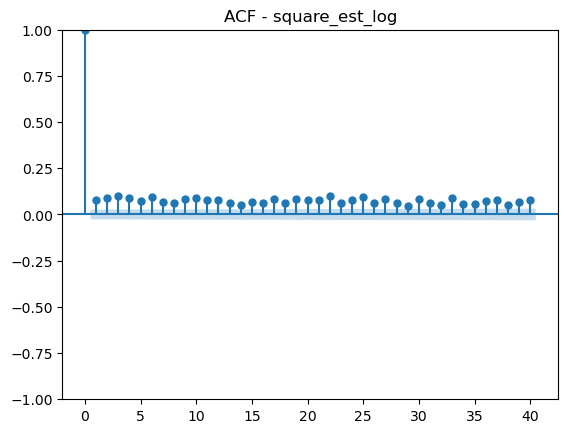

c:\Users\lawor\anaconda3v0\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


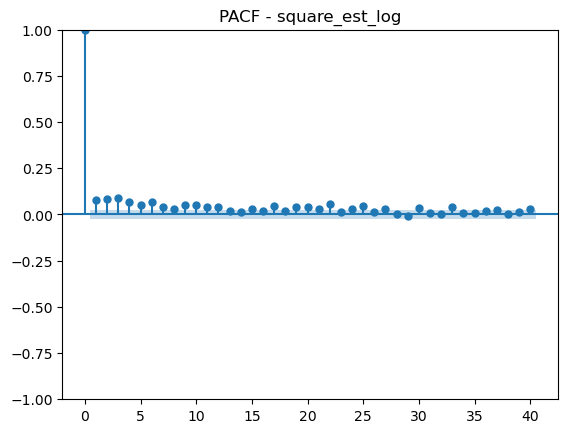

=== parkinson_est_log ===


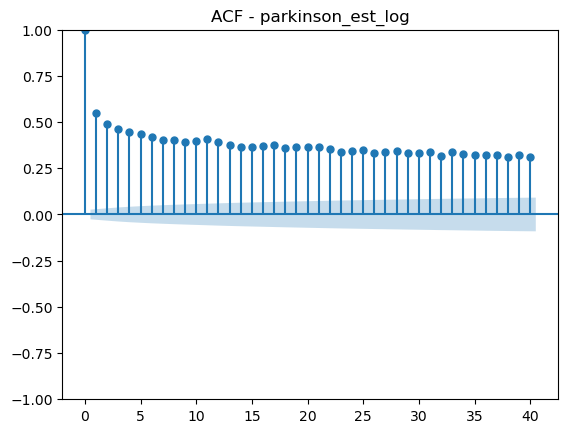

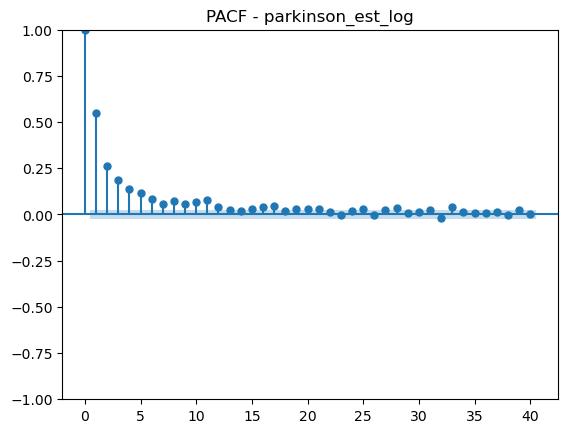

=== gk_est_log ===


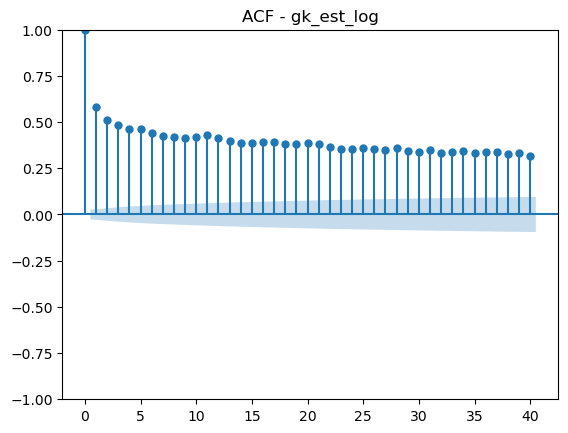

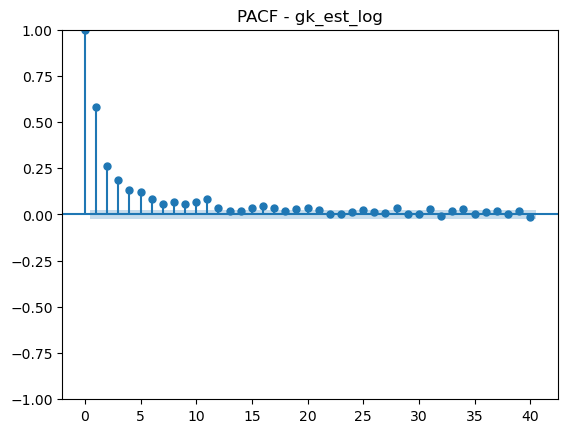

=== rs_est_log ===


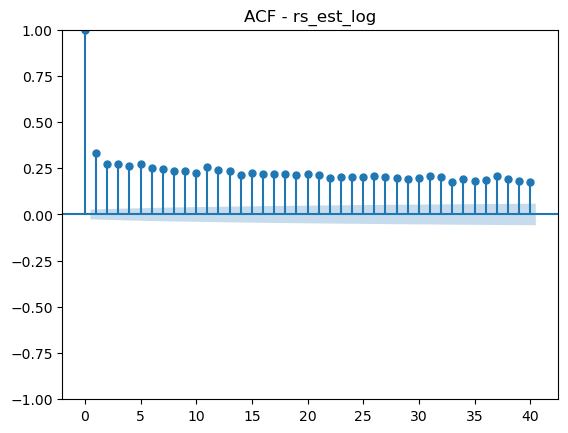

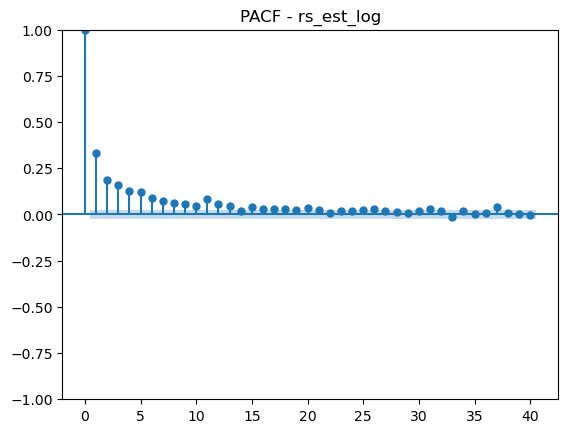

In [30]:
# Plot ACF and PACF for each log-vol estimator
for col in vol_estimator_check.columns:
    print(f"=== {col} ===")
    vol_check.plot_acf(vol_estimator_check[col], nlags=40, title=f"ACF - {col}")
    vol_check.plot_pacf(vol_estimator_check[col], nlags=40, title=f"PACF - {col}")

### Premodel check on the data
- All estimators pass the ADF test, indicating it is mean stationary. Can proceed with HAR model fitting.
- HAR model requires the data to be covariance-stationary, which your ADF result already supports.
- All fail the KPSS test, suggesting that there is trend-stationary / near-unit-root behaviour, which is expected in volatility data case.
- All ACF shows slow decay, indicating long memory.
- PACF has significant spikes up to ~5–15 lags → short-term AR effects + persistent long-term influence.

### What it means in HAR (1,5,22) models?
- HAR(1) → daily dependence (lag 1)
- HAR(5) → weekly average dependence (captures medium decay)
- HAR(22) → monthly average dependence (captures long tail)

In [31]:
n_total = len(y_predictors)
split_point = int(0.7 * n_total)
#x_variables
train_x = y_predictors.iloc[:split_point]
test_x = y_predictors.iloc[split_point:]

#y_variables
train_y = y_true_log.iloc[:split_point]
test_y = y_true_log.iloc[split_point:]

print("Train X shape:", train_x.shape)
print("Test  X shape:", test_x.shape)
print("Train y shape:", train_y.shape)
print("Test  y shape:", test_y.shape)


Train X shape: (3873, 4)
Test  X shape: (1661, 4)
Train y shape: (3873,)
Test  y shape: (1661,)


In [32]:
train_y

Date
2003-01-03    0.430154
2003-01-06   -6.078336
2003-01-07    1.017547
2003-01-08   -2.570768
2003-01-09   -2.605311
                ...   
2018-05-16   -4.426948
2018-05-17   -4.345962
2018-05-18   -4.412556
2018-05-21   -4.596996
2018-05-22   -2.320175
Name: Close, Length: 3873, dtype: float64

In [33]:
train_x

,square_est_log,parkinson_est_log,gk_est_log,rs_est_log
Date,,,,
2003-01-03,-27.631021,-1.390755,-1.067107,-0.992095
2003-01-06,0.430154,-0.816591,-1.113344,-1.309625
2003-01-07,-6.078336,-1.243867,-1.047048,-1.042624
2003-01-08,1.017547,0.190090,0.069264,-0.049774
2003-01-09,-2.570768,-2.283399,-2.082134,-2.121894
...,...,...,...,...
2018-05-16,-7.076497,-2.910120,-2.674251,-2.672605
2018-05-17,-4.426948,-2.914138,-2.645575,-2.413213
2018-05-18,-4.345962,-2.742372,-2.724613,-2.663877


In [34]:
print(train_x.describe())
print(train_y.describe())


       square_est_log  parkinson_est_log   gk_est_log   rs_est_log
count     3873.000000        3873.000000  3873.000000  3873.000000
mean        -3.465054          -2.405917    -2.366836    -2.440105
std          3.291297           1.025223     0.975485     1.364508
min        -27.631021          -5.508949    -5.213705   -27.631021
25%         -4.591955          -3.133824    -3.060615    -3.113289
50%         -2.919714          -2.427602    -2.392680    -2.427163
75%         -1.636726          -1.746478    -1.717309    -1.721835
max          3.861774           2.008054     2.327663     2.812139
count    3873.000000
mean       -3.458519
std         3.268350
min       -27.631021
25%        -4.589417
50%        -2.918631
75%        -1.636726
max         3.861774
Name: Close, dtype: float64


In [49]:
window = [252, 504, 756, 1008, 1260]
estimators = ['square_est_log', 'parkinson_est_log', 'gk_est_log', 'rs_est_log']
per_est = {w: {} for w in window}
per_pred = {w: {} for w in window}
per_residual = {w: {} for w in window}
pred_raw_residual = {w: {} for w in window}

df_pred = {}
df_pred_adj = {}
df_residual = {}
df_residual_adj = {}
qlike_loss_df = {}
mspe_loss_df = {}
yhat_var = {}
summary_df = {}
ljung_box_df = {}


for w in window:

  for est in estimators:
    har = HAR_Model(y_log_col=est, exo_col=None)
    x_est = har.features(train_x)
    y_adj = train_y.loc[x_est.index]
    per_est[w][est] = x_est

    y_pred, resid_pred, residual_raw = har.fit_predict(x_est ,y_adj, window=w)

    per_pred[w][est] = y_pred
    per_residual[w][est] = resid_pred
    pred_raw_residual[w][est] = residual_raw
  
  df_pred[w] = pd.DataFrame(per_pred[w])
  df_pred_adj[w] = df_pred[w].dropna()
  df_residual[w] = pd.DataFrame(pred_raw_residual[w])
  df_residual_adj[w] = df_residual[w].dropna()
  residual_input = df_residual_adj[w]

  #variance scale
  yhat_var[w] = np.exp(df_pred_adj[w])
  ytrue_var = np.exp(train_y)
  common_idx = yhat_var[w].index.intersection(ytrue_var.index)
  yhat = yhat_var[w].loc[common_idx]
  ytrue = ytrue_var.loc[common_idx]

  qlike_loss_df[w] = pd.DataFrame({col: Metric_Evaluation.qlike(ytrue, yhat[col])
                                for col in yhat.columns})
  mspe_loss_df[w]  = pd.DataFrame({col: Metric_Evaluation.mspe(ytrue, yhat[col])
                                for col in yhat.columns})
  summary_df[w] = pd.DataFrame({
    'QLIKE_mean': qlike_loss_df[w].mean(),
    'QLIKE_std':  qlike_loss_df[w].std(),
    'MSPE_mean':  mspe_loss_df[w].mean(),
    'MSPE_std':   mspe_loss_df[w].std()
  }).round(4)

  vol_check = Vol_Est_Check(
      alpha=0.05,
      lb_lags=(10, 20),
      kpss_reg='c',
      kpss_nlags='auto',
      acf_pacf_nlags=40
  )
  ljung_box_df[w] = pd.DataFrame({col: vol_check.ljung_box(residual_input[col])
                              for col in residual_input.columns})

In [50]:
final_summary = pd.concat(summary_df, axis=0)
final_summary.index.name = 'Window'

ljung_box_summary = pd.concat(ljung_box_df, axis=0)
ljung_box_summary.index.name = 'Window'

print(final_summary)
print(ljung_box_summary)


                        QLIKE_mean  QLIKE_std     MSPE_mean      MSPE_std
252  square_est_log         4.0641    35.7613  1.514000e+19  2.995661e+20
     parkinson_est_log      3.4802    25.8719  1.414954e+19  2.889972e+20
     gk_est_log             3.5405    27.8541  1.384992e+19  2.819214e+20
     rs_est_log            92.3308  4032.4303  1.413068e+19  2.572518e+20
504  square_est_log         3.7177    30.7072  1.415470e+19  2.717311e+20
     parkinson_est_log      3.4422    23.5815  9.363379e+18  2.146401e+20
     gk_est_log             3.4248    23.3103  8.818988e+18  1.841544e+20
     rs_est_log            25.8428   751.1897  1.039181e+19  1.979542e+20
756  square_est_log         3.8950    34.1754  1.128180e+19  1.894703e+20
     parkinson_est_log      3.7485    27.6018  8.738954e+18  2.002590e+20
     gk_est_log             3.7604    26.9045  8.340125e+18  1.935334e+20
     rs_est_log            44.0139  2172.8317  9.027108e+18  1.997904e+20
1008 square_est_log         3.7431    

<Figure size 1600x700 with 0 Axes>

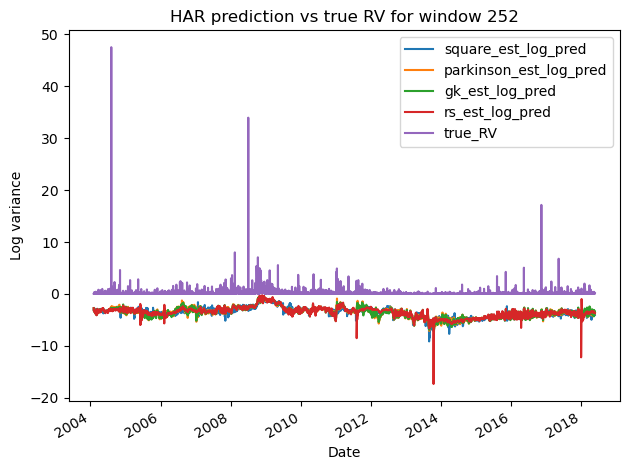

<Figure size 1600x700 with 0 Axes>

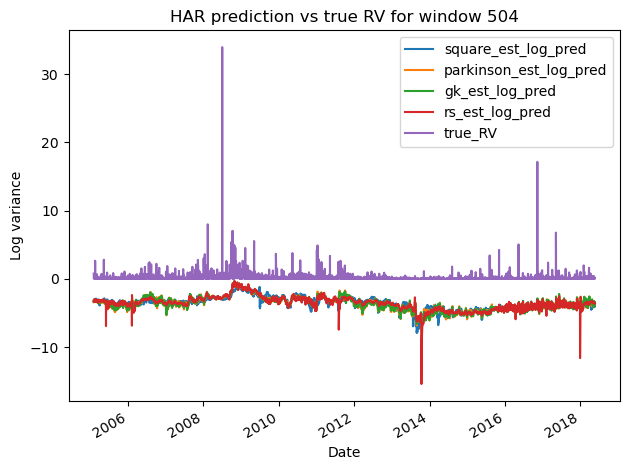

<Figure size 1600x700 with 0 Axes>

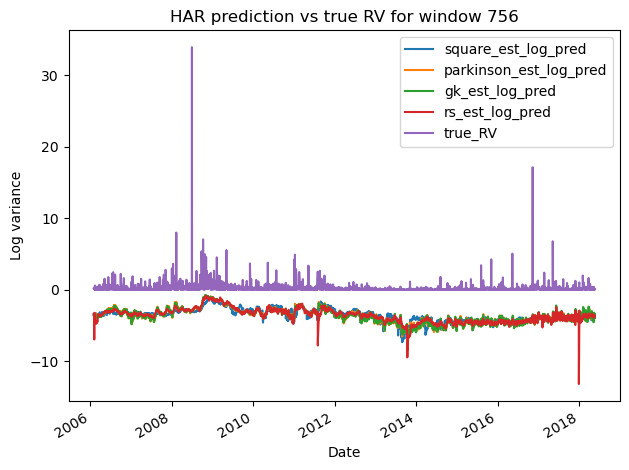

<Figure size 1600x700 with 0 Axes>

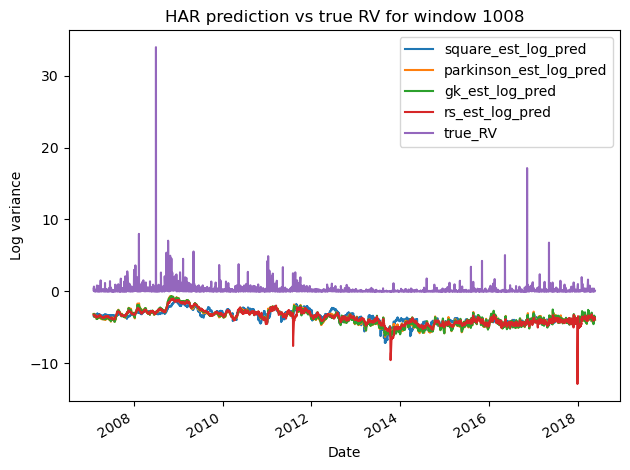

<Figure size 1600x700 with 0 Axes>

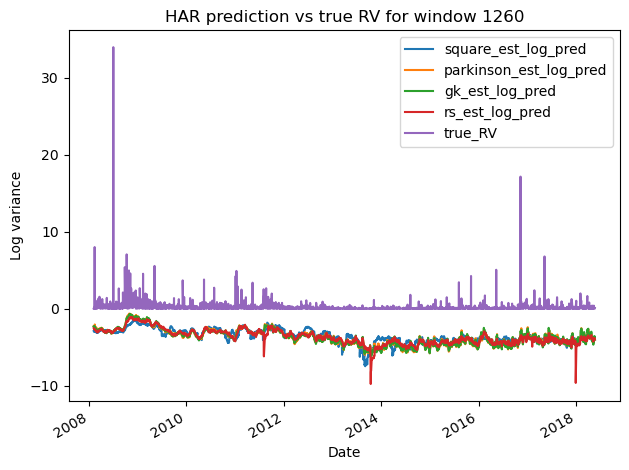

In [ ]:
# plot log variance scale
window = [252, 504, 756, 1008, 1260]

for w in window:
  common_idx = df_pred_adj[w].index.intersection( y_adj.index)
  yhat_plot = df_pred_adj[w].loc[common_idx]
  yhat_plot.columns = [f"{col}_pred" for col in yhat_plot.columns]

  ytrue_plot = ytrue_var.loc[common_idx].to_frame(name = 'true_RV')

  y_plot = pd.concat([yhat_plot, ytrue_plot], axis = 1)
  
  plt.figure(figsize=[16,7])
  y_plot.plot()
  plt.xlabel("Date")
  plt.ylabel("Log variance")
  plt.legend()
  plt.title(f"HAR prediction vs true RV for window {w}")
  plt.tight_layout()
  plt.show()


<Figure size 1600x700 with 0 Axes>

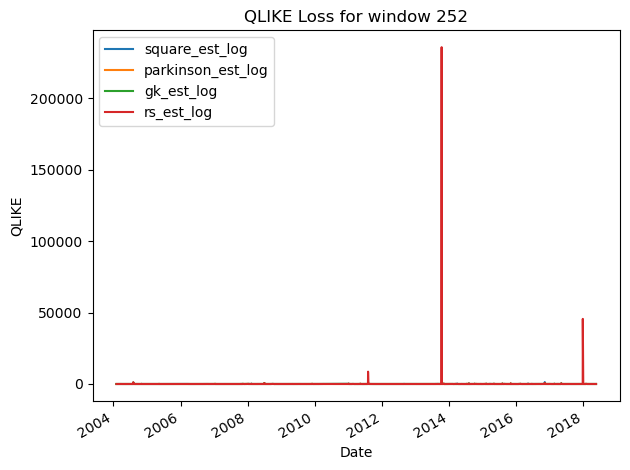

<Figure size 1600x700 with 0 Axes>

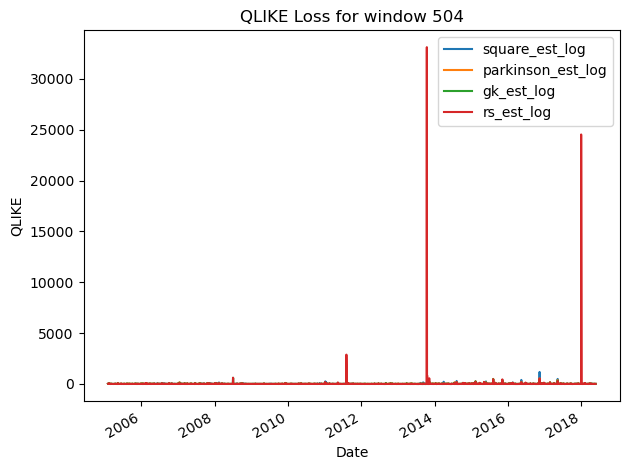

<Figure size 1600x700 with 0 Axes>

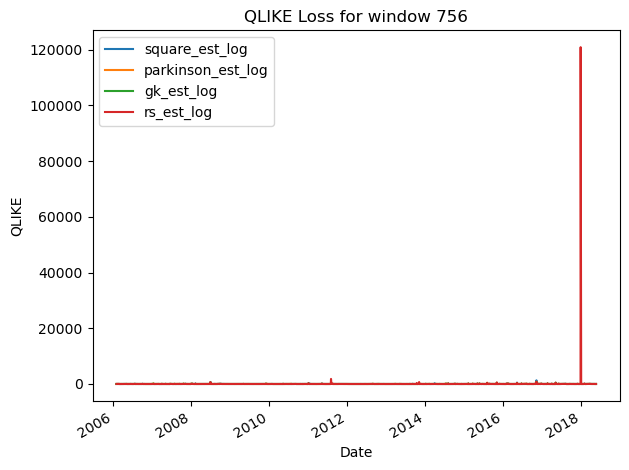

<Figure size 1600x700 with 0 Axes>

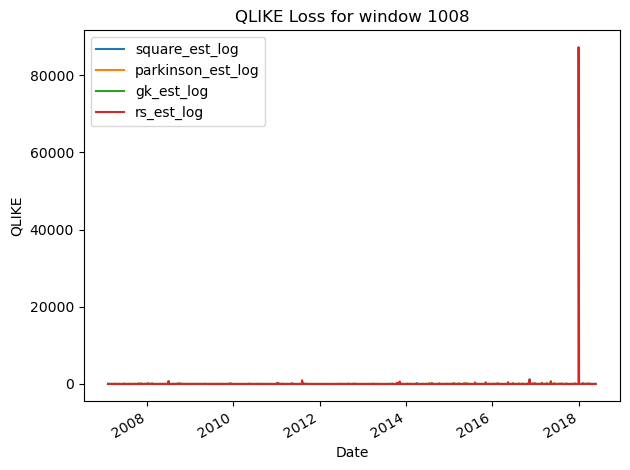

<Figure size 1600x700 with 0 Axes>

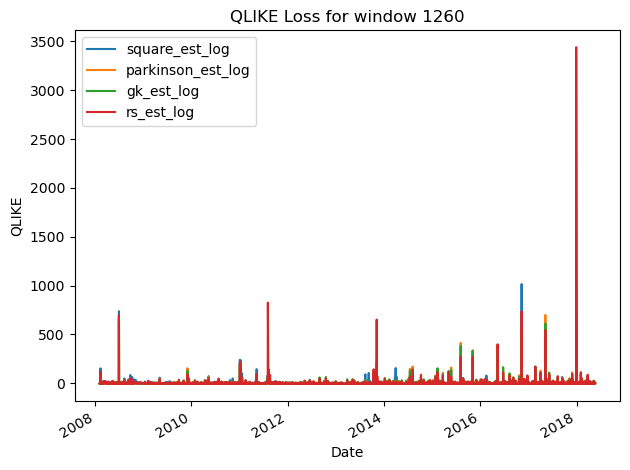

In [52]:
# IN variance scale
for w in window:
  plt.figure(figsize=[16,7])
  qlike_loss_df[w][['square_est_log', 'parkinson_est_log', 'gk_est_log', 'rs_est_log']].plot()
  plt.xlabel("Date")
  plt.ylabel("QLIKE")
  plt.legend()
  plt.title(f"QLIKE Loss for window {w}")
  plt.tight_layout()
  plt.show()


<Figure size 1600x700 with 0 Axes>

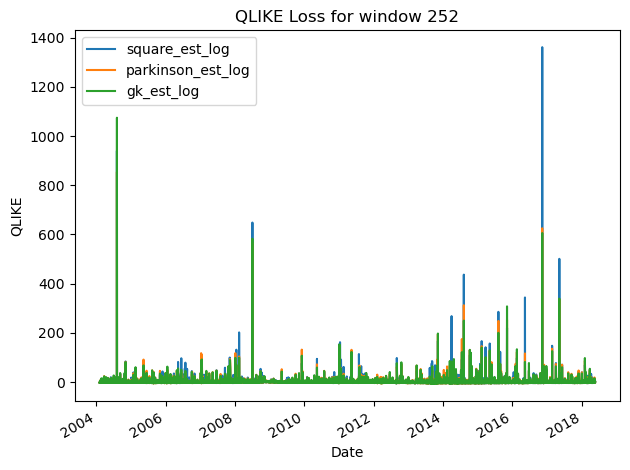

<Figure size 1600x700 with 0 Axes>

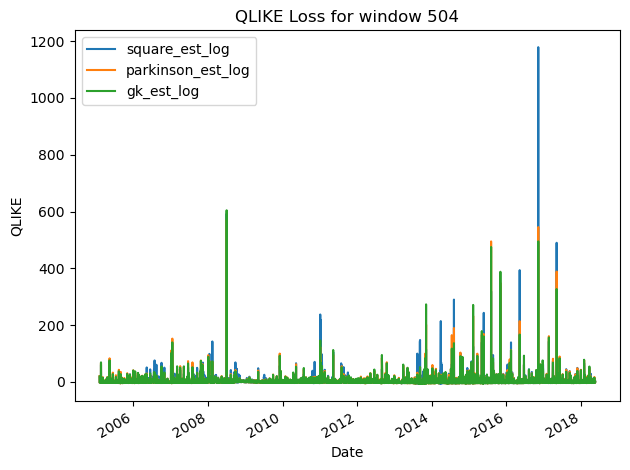

<Figure size 1600x700 with 0 Axes>

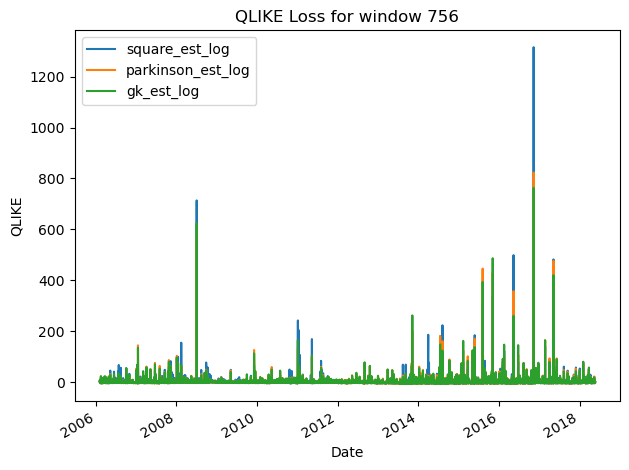

<Figure size 1600x700 with 0 Axes>

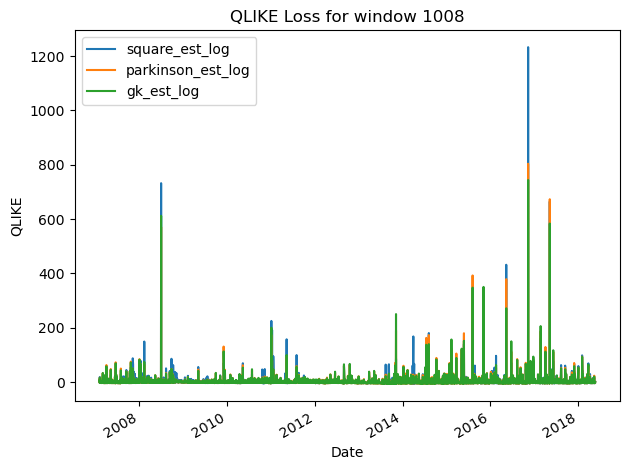

<Figure size 1600x700 with 0 Axes>

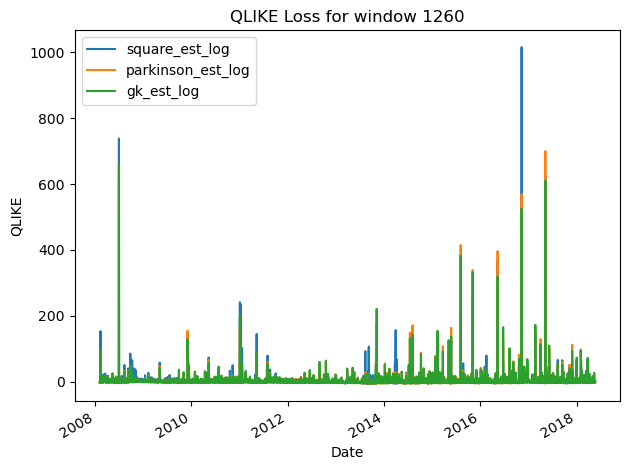

In [54]:
# IN variance scale
for w in window:
  plt.figure(figsize=[16,7])
  qlike_loss_df[w][['square_est_log', 'parkinson_est_log', 'gk_est_log']].plot()
  plt.xlabel("Date")
  plt.ylabel("QLIKE")
  plt.legend()
  plt.title(f"QLIKE Loss for window {w}")
  plt.tight_layout()
  plt.show()

<Figure size 1600x700 with 0 Axes>

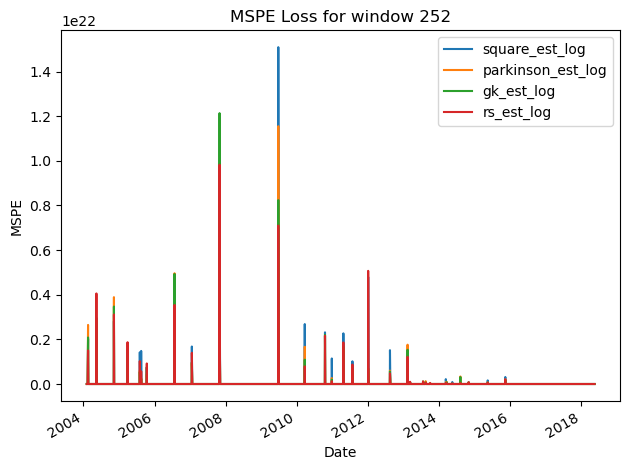

<Figure size 1600x700 with 0 Axes>

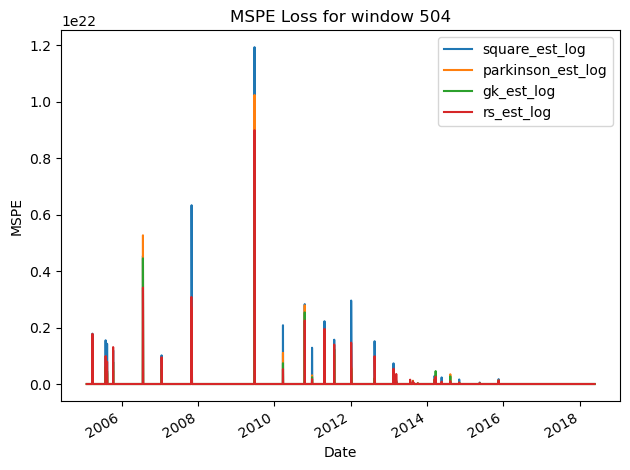

<Figure size 1600x700 with 0 Axes>

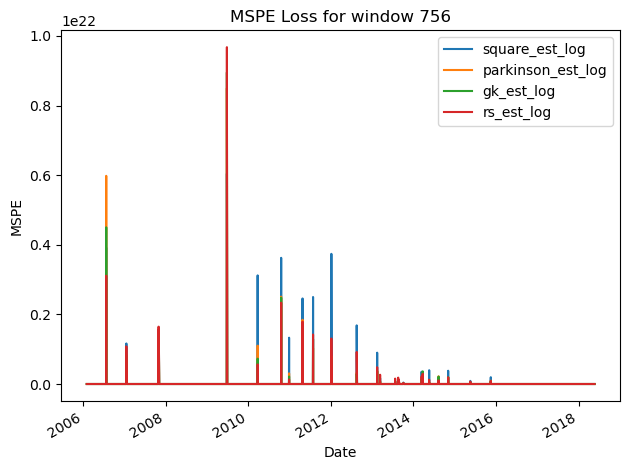

<Figure size 1600x700 with 0 Axes>

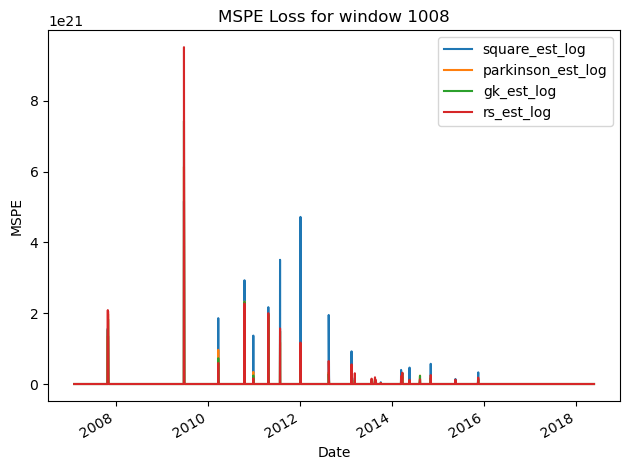

<Figure size 1600x700 with 0 Axes>

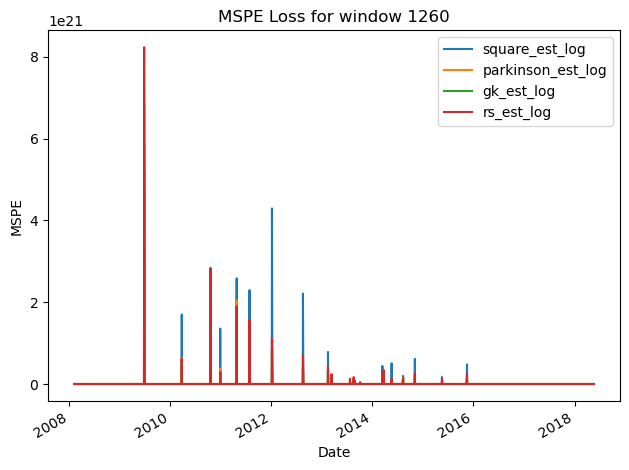

In [53]:
#in variance scale
for w in window:
  plt.figure(figsize=[16,7])
  mspe_loss_df[w][['square_est_log', 'parkinson_est_log', 'gk_est_log', 'rs_est_log']].plot()
  plt.xlabel("Date")
  plt.ylabel("MSPE")
  plt.legend()
  plt.title(f"MSPE Loss for window {w}")
  plt.tight_layout()
  plt.show()

### Findings:
- RS estimator perform the worst for all windows. Henec RS estimator is removed from the ensemble model.

### Ensemble Model - Train/Val Set

In [61]:
# creating ensemble model for all 5 windows
window = [252, 504, 756, 1008, 1260]

qlike_ensemble = {}
wts = {}
weight_ensemble = {}
yhat_ensemble = {}
yhat_enfinal = {}
log_yhat_enfinal = {}
log_yhat_ensemble = {}
residual_ensemble = {}
qlike_loss_ensemble = {}
mspe_loss_ensemble = {}
summary_ensemble = {}
ljung_box_ensemble = {}

for w in window:
  
  #compute weightage
  ensemble_model = EnsembleModel(estimators=None)
  qlike_ensemble[w] = summary_df[w]['QLIKE_mean']
  weight_ensemble[w] = ensemble_model.compute_weightage(qlike_ensemble[w])
  yhat_ensemble[w] = (np.exp(df_pred_adj[w]))
  
  wts[w] = pd.Series(weight_ensemble[w], index=yhat_ensemble[w].columns, dtype=float)

  yhat_enfinal[w] = yhat_ensemble[w].dot(wts[w])
  log_yhat_enfinal[w] = np.log(  yhat_enfinal[w])

  common_idx = log_yhat_enfinal[w].index.intersection(y_adj.index)
  log_yhat_ensemble[w] = log_yhat_enfinal[w].loc[common_idx] #log-variance
  log_ytrue_ensemble = y_adj.loc[common_idx] #log-variance
  ytrue_ensemble = ytrue_var.loc[common_idx] # variance

  residual_ensemble[w] = log_yhat_ensemble[w] - log_ytrue_ensemble

  qlike_loss_ensemble[w] = pd.DataFrame(Metric_Evaluation.qlike(ytrue_ensemble, yhat_enfinal[w]))
  mspe_loss_ensemble[w]  = pd.DataFrame(Metric_Evaluation.mspe(ytrue_ensemble, yhat_enfinal[w]))

  summary_ensemble[w] = pd.DataFrame({
    'QLIKE_mean': qlike_loss_ensemble[w].mean(),
    'QLIKE_std':  qlike_loss_ensemble[w].std(),
    'MSPE_mean':  mspe_loss_ensemble[w].mean(),
    'MSPE_std':   mspe_loss_ensemble[w].std()
  }).round(4)

  vol_check = Vol_Est_Check(
      alpha=0.05,
      lb_lags=(10, 20),
      kpss_reg='c',
      kpss_nlags='auto',
      acf_pacf_nlags=40
  )
  ljung_box_ensemble[w] = pd.DataFrame(vol_check.ljung_box(residual_ensemble[w]))

In [62]:
for w in window:
    print(w, wts[w].round(4))

252 square_est_log       0.2976
parkinson_est_log    0.3476
gk_est_log           0.3417
rs_est_log           0.0131
dtype: float64
504 square_est_log       0.3022
parkinson_est_log    0.3264
gk_est_log           0.3280
rs_est_log           0.0435
dtype: float64
756 square_est_log       0.3161
parkinson_est_log    0.3285
gk_est_log           0.3274
rs_est_log           0.0280
dtype: float64
1008 square_est_log       0.3203
parkinson_est_log    0.3216
gk_est_log           0.3243
rs_est_log           0.0339
dtype: float64
1260 square_est_log       0.2790
parkinson_est_log    0.2731
gk_est_log           0.2758
rs_est_log           0.1721
dtype: float64


In [63]:
final_summary_ensemble = pd.concat(summary_ensemble, axis=0)
final_summary_ensemble.index.name = 'Window'

lb_ensemble_final = pd.concat(ljung_box_ensemble, axis=0)
lb_ensemble_final.index.name = 'Window'

print(final_summary_ensemble)
print(lb_ensemble_final)

        QLIKE_mean  QLIKE_std     MSPE_mean      MSPE_std
252  0      3.2403    27.4576  1.373655e+19  2.610082e+20
504  0      3.0858    23.2798  1.033626e+19  2.146328e+20
756  0      3.3917    27.6915  9.115386e+18  1.859323e+20
1008 0      3.3294    28.9477  7.846287e+18  1.507249e+20
1260 0      3.1733    27.9554  7.268788e+18  1.511005e+20
        lb_stat_10   lb_p_10  lb_stat_20   lb_p_20  white_noise_flag  \
252  0    7.894570  0.639134   13.297326  0.864266              True   
     1    7.894570  0.639134   13.297326  0.864266              True   
504  0    8.714550  0.559391   12.150853  0.910786              True   
     1    8.714550  0.559391   12.150853  0.910786              True   
756  0    8.541493  0.576098   12.891579  0.881987              True   
     1    8.541493  0.576098   12.891579  0.881987              True   
1008 0   11.700738  0.305584   16.732670  0.670258              True   
     1   11.700738  0.305584   16.732670  0.670258              True   
1260

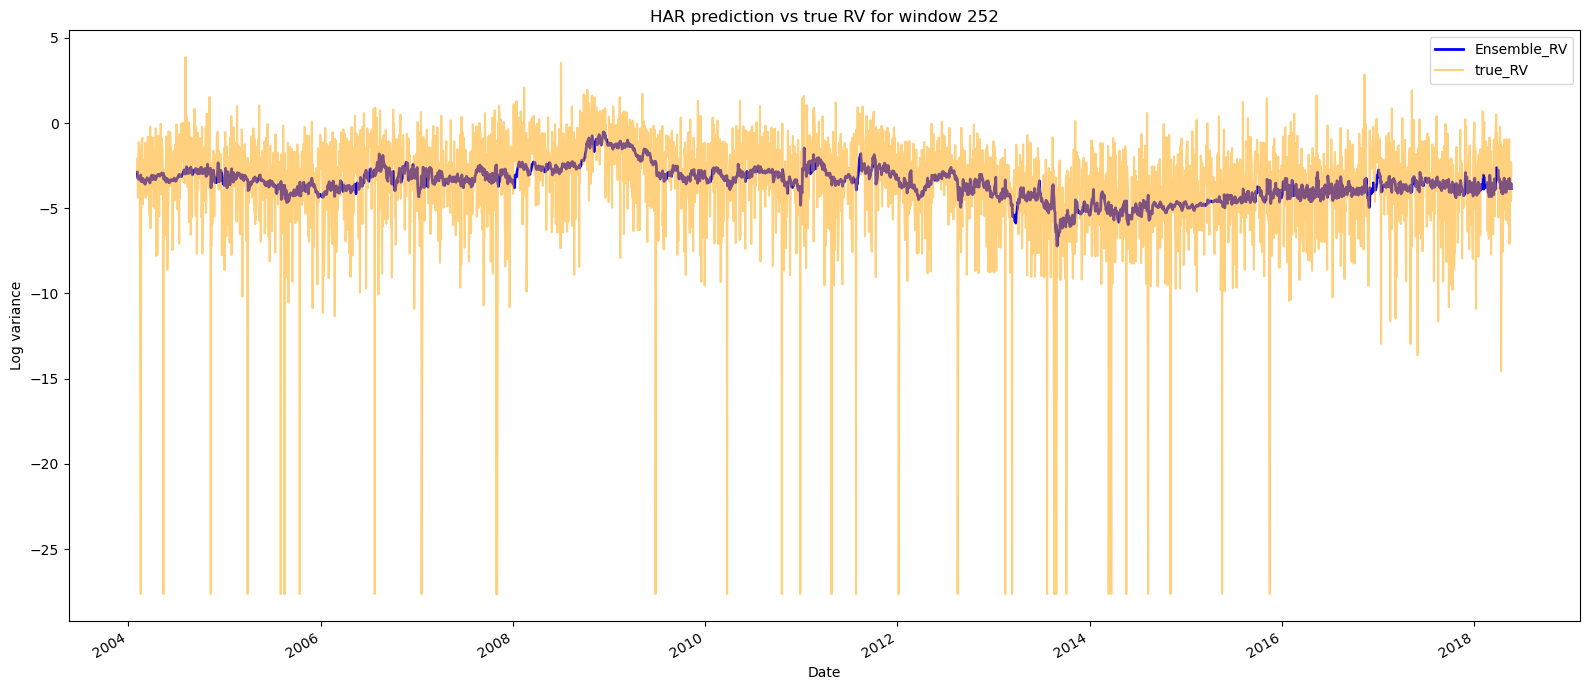

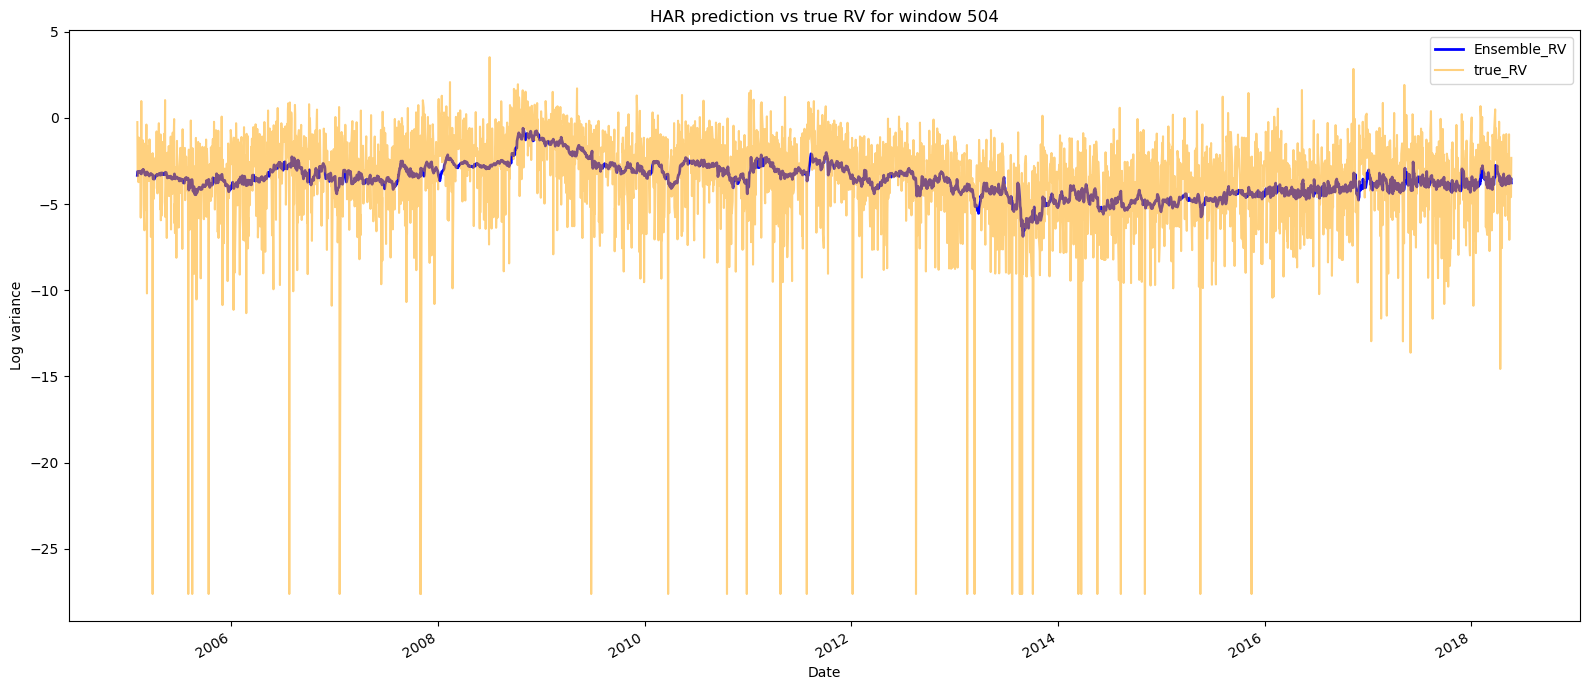

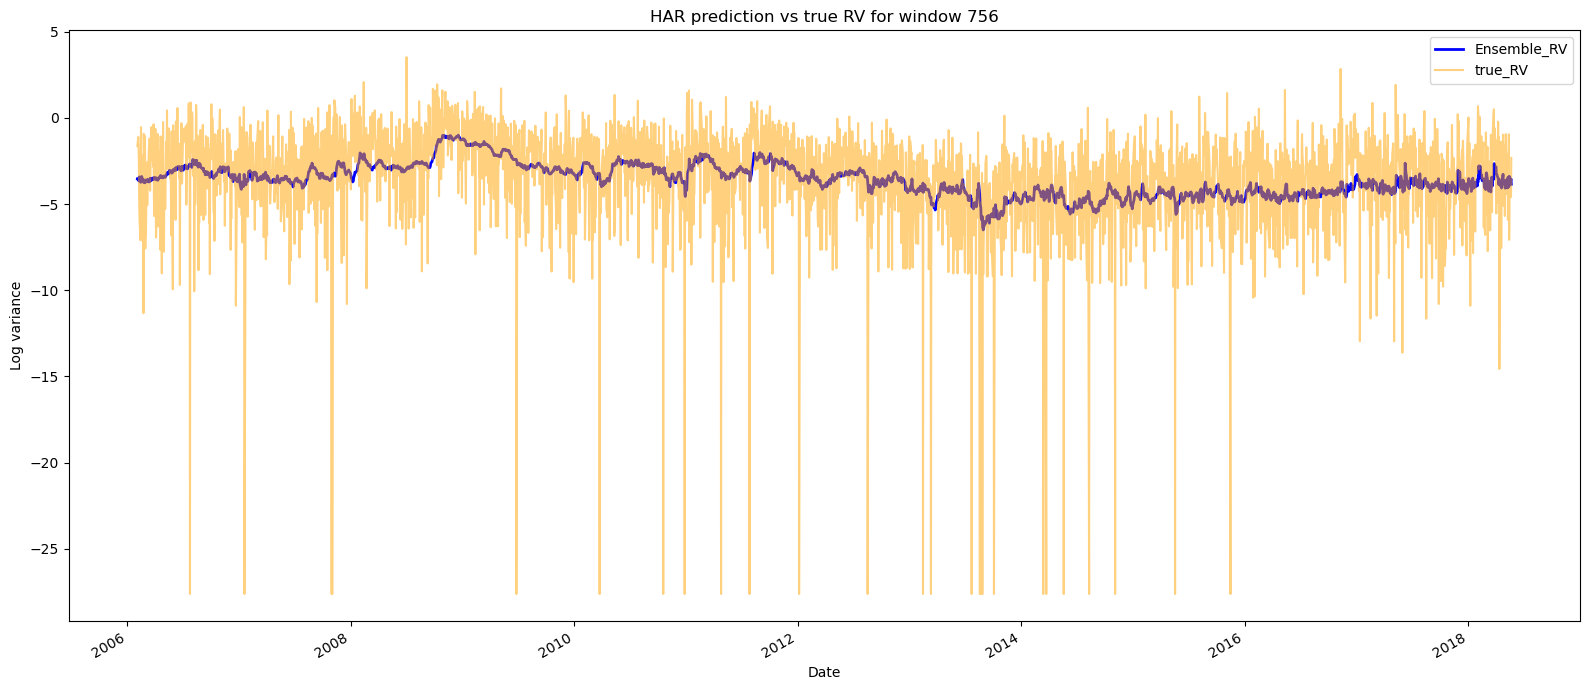

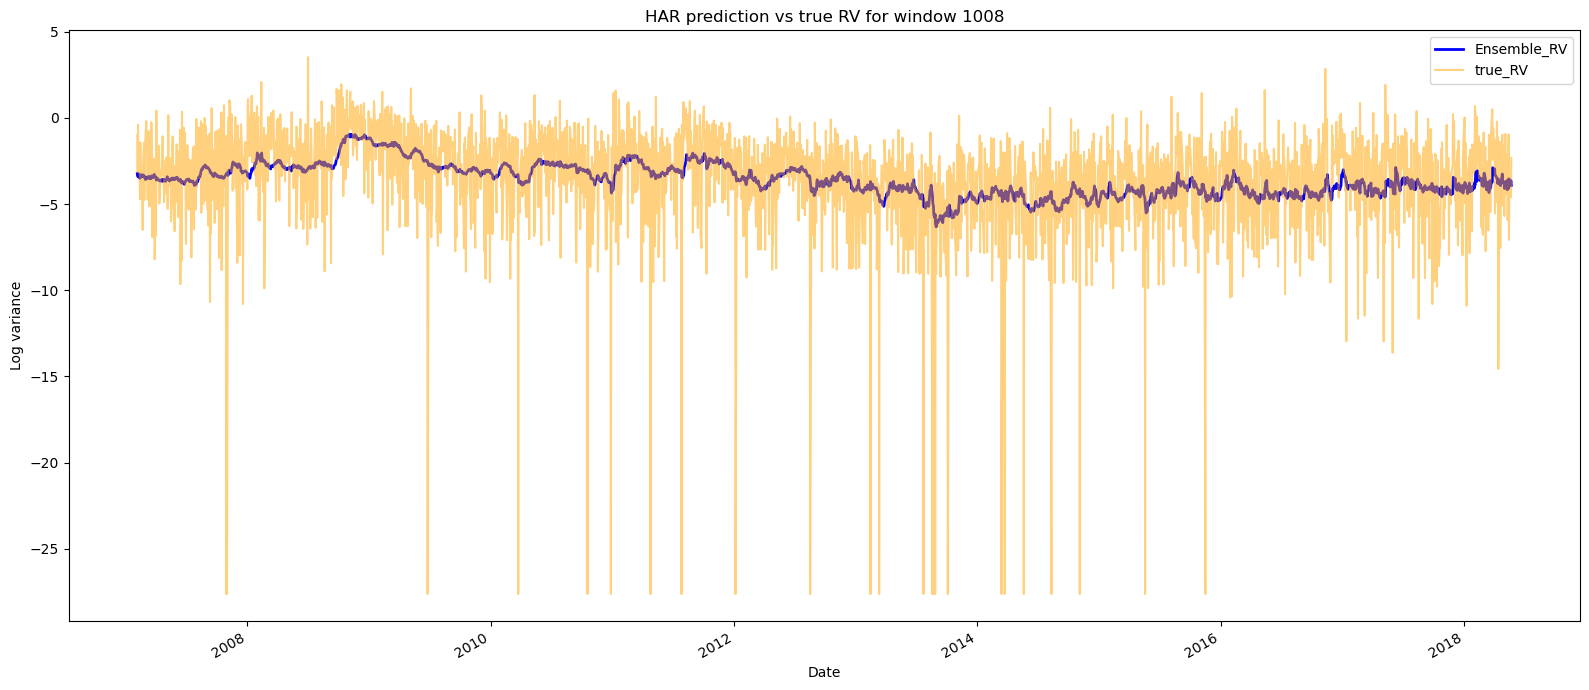

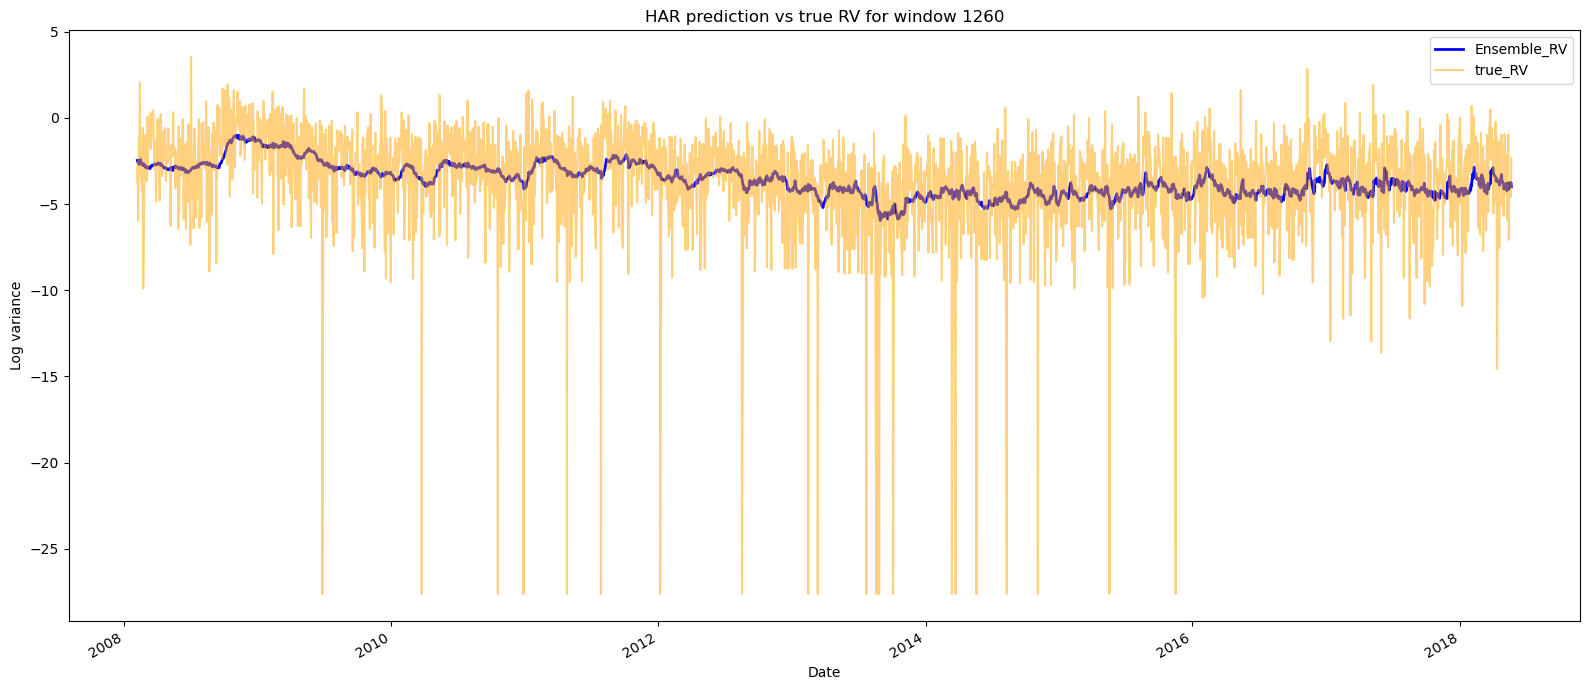

In [65]:
# plot log variance scale
window = [252, 504, 756, 1008, 1260]
for w in window:
  common_idx = log_yhat_enfinal[w].index.intersection(y_adj.index)
  yhat_plot = log_yhat_enfinal[w].loc[common_idx].to_frame(name = 'Ensemble_RV') #log-variance
  ytrue_plot = y_adj.loc[common_idx].to_frame(name = 'true_RV') #log-variance

  y_plot = pd.concat([yhat_plot, ytrue_plot], axis = 1)

  fig, ax = plt.subplots(figsize=(16, 7))
  yhat_plot.plot(ax=ax, color='blue', linewidth=2, label='Ensemble_RV')
  ytrue_plot.plot(ax=ax, color='orange', linewidth=1.5, alpha=0.5, label='true_RV')
  plt.xlabel("Date")
  plt.ylabel("Log variance")
  plt.legend()
  plt.title(f"HAR prediction vs true RV for window {w}")
  plt.tight_layout()
  plt.show()

<Figure size 1600x700 with 0 Axes>

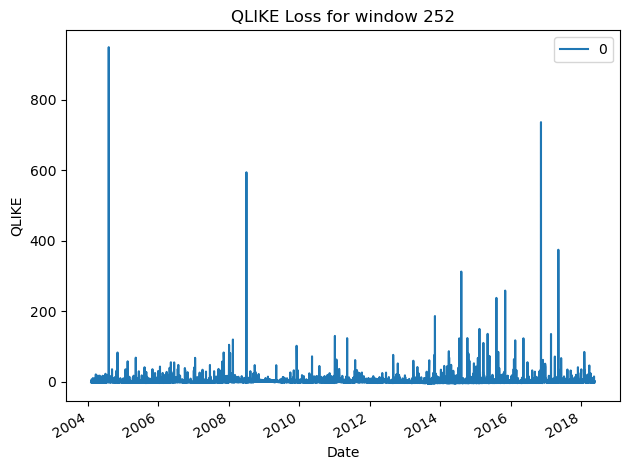

<Figure size 1600x700 with 0 Axes>

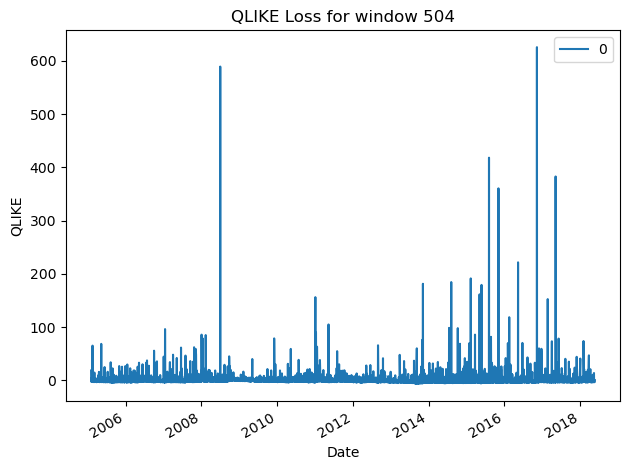

<Figure size 1600x700 with 0 Axes>

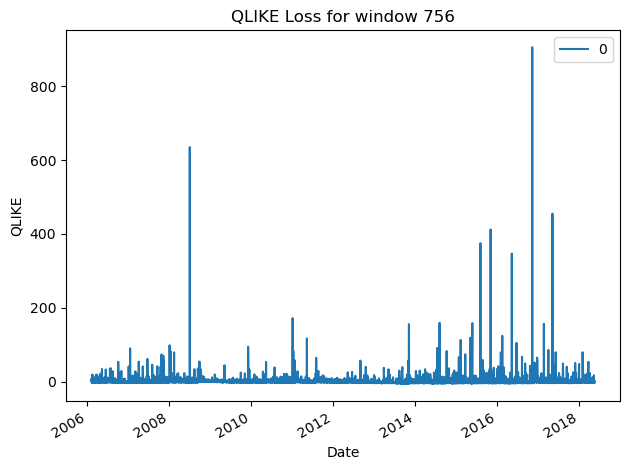

<Figure size 1600x700 with 0 Axes>

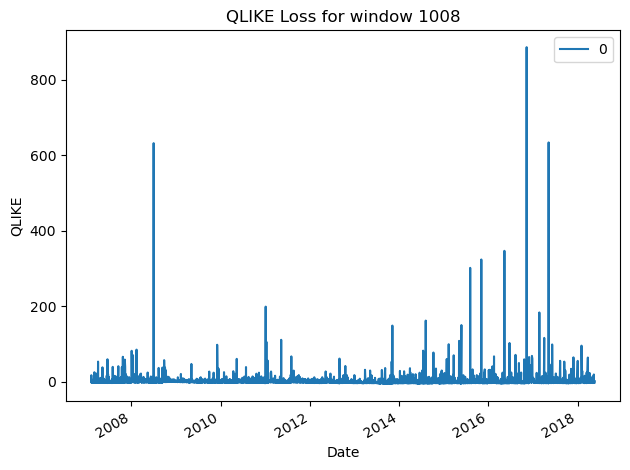

<Figure size 1600x700 with 0 Axes>

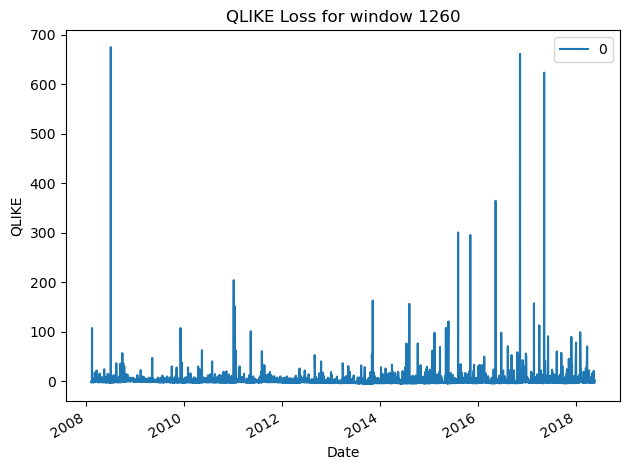

In [70]:
# IN variance scale
for w in window:
  plt.figure(figsize=[16,7])
  qlike_loss_ensemble[w].plot()
  plt.xlabel("Date")
  plt.ylabel("QLIKE")
  plt.title(f"QLIKE Loss for window {w}")
  plt.tight_layout()
  plt.show()
  

<Figure size 1600x700 with 0 Axes>

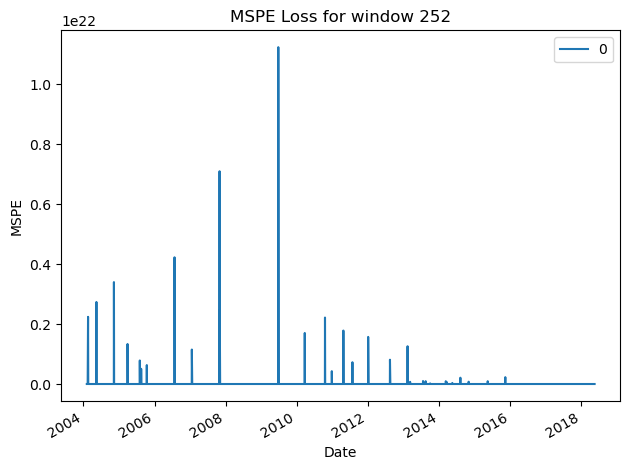

<Figure size 1600x700 with 0 Axes>

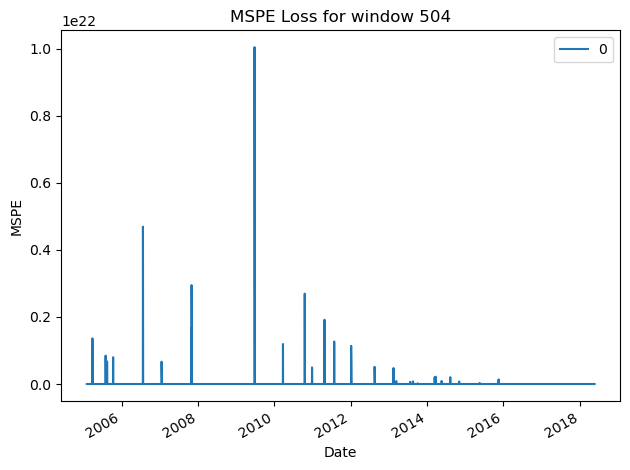

<Figure size 1600x700 with 0 Axes>

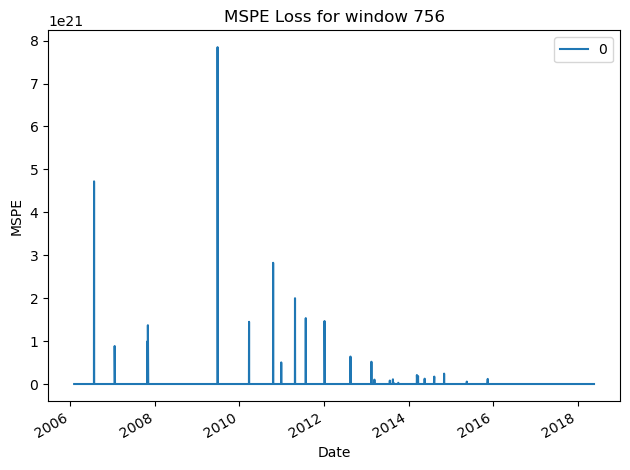

<Figure size 1600x700 with 0 Axes>

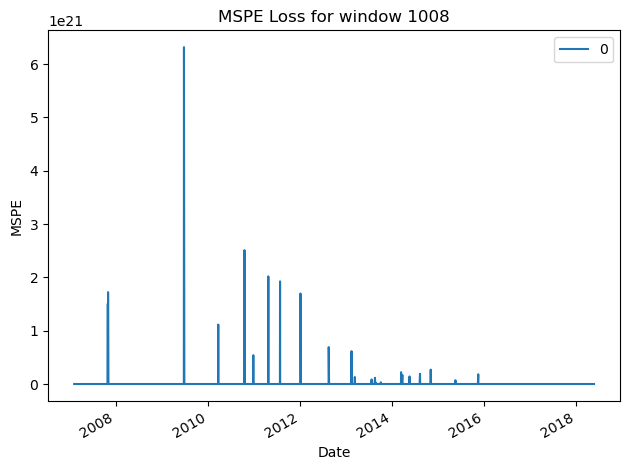

<Figure size 1600x700 with 0 Axes>

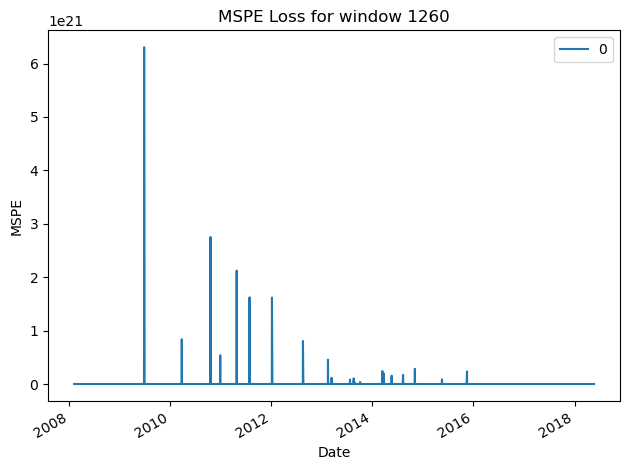

In [69]:
#in variance scale
for w in window:
  plt.figure(figsize=[16,7])
  mspe_loss_ensemble[w].plot()
  plt.xlabel("Date")
  plt.ylabel("MSPE")
  plt.legend()
  plt.title(f"MSPE Loss for window {w}")
  plt.tight_layout()
  plt.show()

=== 252 ===


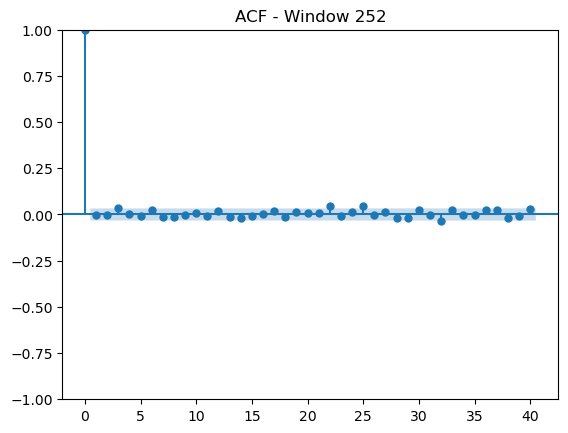

c:\Users\lawor\anaconda3v0\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


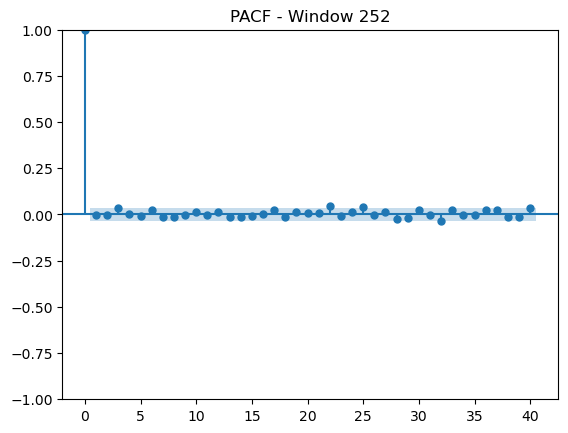

=== 504 ===


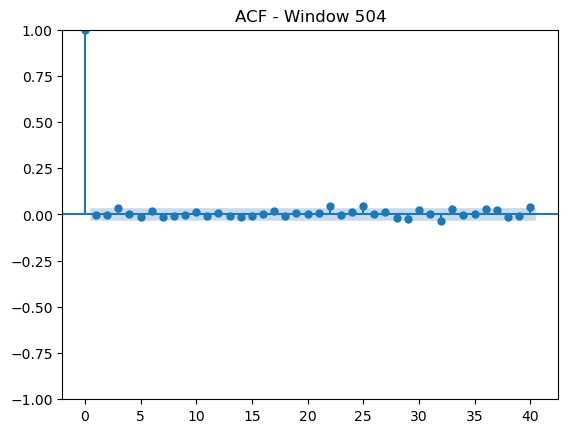

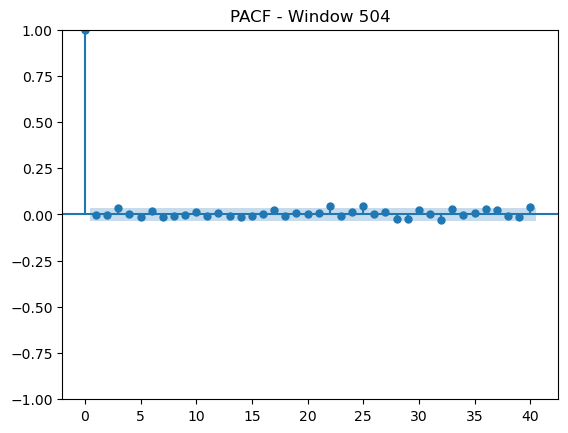

=== 756 ===


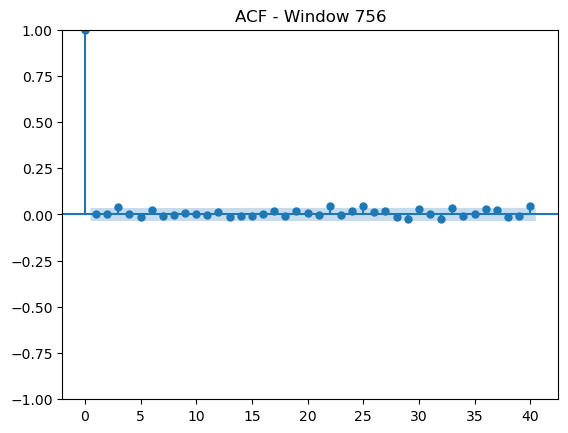

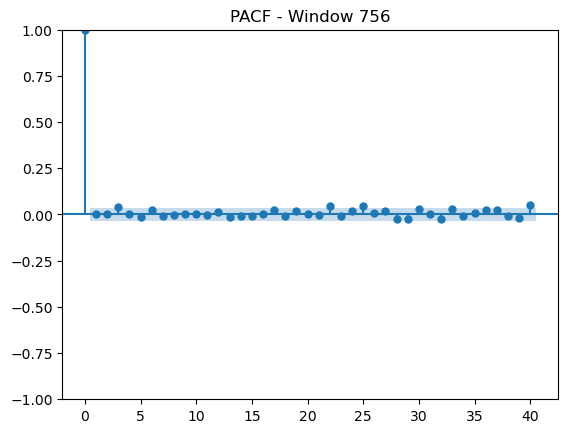

=== 1008 ===


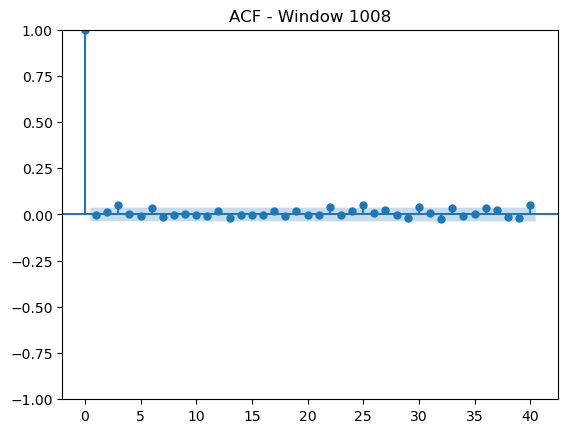

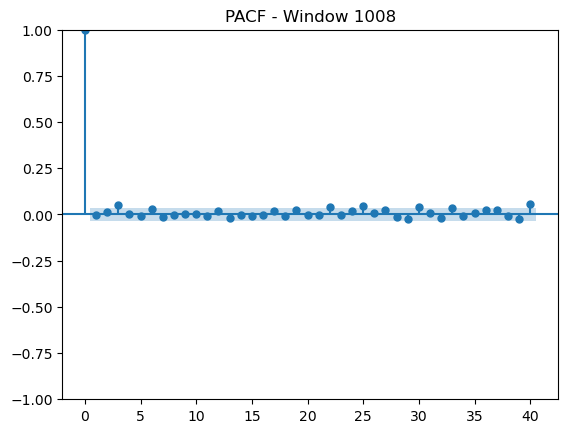

=== 1260 ===


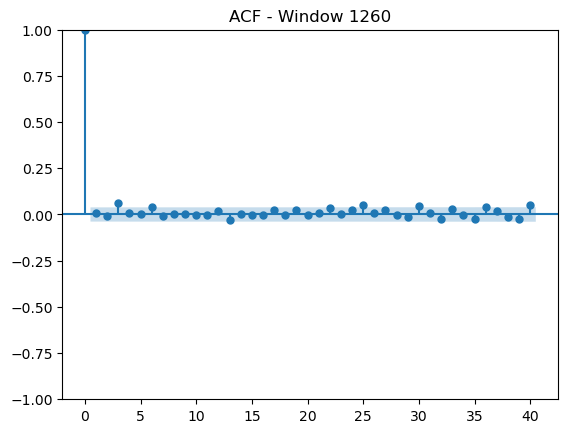

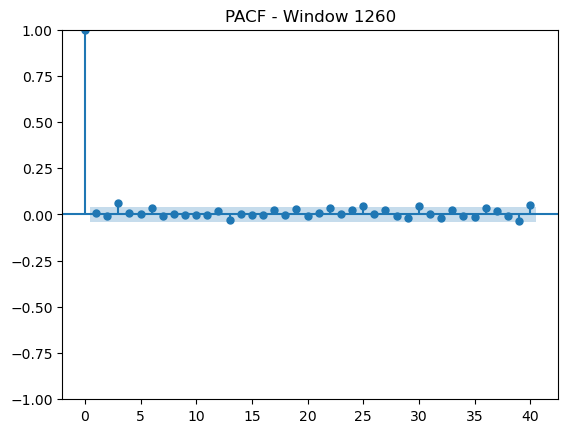

In [71]:
# plot acf and pacf
for w in window:
    print(f"=== {w} ===")
    vol_check.plot_acf(residual_ensemble[w], nlags=40, title=f"ACF - Window {w}")
    vol_check.plot_pacf(residual_ensemble[w], nlags=40, title=f"PACF - Window {w}")



## Evaluation from the ensemble model
- Windows = [252, 504, 756, 1008, 1260]
- Overall forecast calibration (QLIKE) : 504 perform best
- Raw forecast error magnitude (MSPE): 1260 perform best
- Ljung box test: All windows passed
- PACF and ACF plots for all windows: No significant autocorrelataion beyond lag 0. Residuals behave like white noise. Indication of the ability to capture the volatility dynamics.
- Hence windows 504 and 1260 will run through the DM test to check for pairwise statistical validation (Test whether the difference in predictive loss is statistically significant)

In [ ]:
#window = [504, 1260]
loss1 = qlike_loss_ensemble[504]
loss2 = qlike_loss_ensemble[1260]
common_idx = loss2.index.intersection( loss1.index)
loss2_adj = loss2.loc[common_idx]
loss1_adj = loss1.loc[common_idx]

DM_test_results = Metric_Evaluation.DM_test(loss1_adj, 
                                            loss2_adj, 
                                            model1_name='Window_504', 
                                            model2_name='Window_1260'
                                            )
print(DM_test_results)

# p value = 0.8222 >0.05, fail to reject Ho of equal predictive accuracy.
#indicates no statistically significant difference in predictive accuracy between window 504 and 1260. 
# Therefore, either window may be used, and selection can be based on secondary metrics or practical considerations.

(0.22476175816416988, 0.822164617457602, {'Better model': 'None (No significant difference)', 'Significant': False, 'Alpha': 0.05, 'Observations': 2592})


In [76]:
for w in window:
    print(f'\n Window {w}')
    a = qlike_loss_ensemble[w].describe()
    print(a)


 Window 252
                 0
count  3600.000000
mean      3.240275
std      27.457616
min      -7.059993
25%      -2.982461
50%      -1.400261
75%       2.445518
max     949.976340

 Window 504
                 0
count  3348.000000
mean      3.085754
std      23.279803
min      -6.763589
25%      -3.042714
50%      -1.402585
75%       2.501652
max     625.947219

 Window 756
                 0
count  3096.000000
mean      3.391668
std      27.691539
min      -6.422966
25%      -3.039151
50%      -1.393446
75%       2.485674
max     905.997486

 Window 1008
                 0
count  2844.000000
mean      3.329395
std      28.947683
min      -6.262229
25%      -3.073074
50%      -1.436801
75%       2.268607
max     886.503386

 Window 1260
                 0
count  2592.000000
mean      3.173333
std      27.955409
min      -5.912038
25%      -3.130570
50%      -1.462839
75%       2.243445
max     674.851682
